# _P(s)_ on binned and balanced contact matrices, a.k.a. "expected"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler

In [2]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [3]:
conditions = ['WT', 'T', 'dN']
binsize = 100000

cooler_paths = {    
    'WT' : f'data/UNTR.{binsize}.cool',
    'T'  : f'data/TAM.{binsize}.cool',
    'dN' : f'data/NIPBL.{binsize}.cool',
}
long_names = {
    'WT': 'Wildtype',
    'T' : 'TAM',
    'dN': 'NipblKO',
}
pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'T' : '#333333',
    'dN': pal[2],
}

clrs = {
    cond: cooler.Cooler(cooler_paths[cond]) for cond in conditions
}

In [4]:
# this cell takes a long time to run
from cooltools.expected import diagsum, blocksum_pairwise
supports = [(chrom, 0, chromsizes[chrom]) for chrom in chromosomes]


cis_exp = {}
trs_exp = {}

with mp.Pool() as pool:
    for cond in conditions:
        
        print(cond, 'cis')
        tables = diagsum(
            clrs[cond], 
            supports, 
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2'],
            },
            chunksize=10000000,
            ignore_diags=2, 
            map=pool.map)
        
        cis_exp[cond] = pd.concat(
            [tables[support] for support in supports], 
            keys=[support[0] for support in supports], 
            names=['chrom'])
        cis_exp[cond]['balanced.avg'] = cis_exp[cond]['balanced.sum'] / cis_exp[cond]['n_valid']
        
        cis_exp[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.expected.cis.tsv', sep='\t')
        
        print(cond, 'trans')
        records = blocksum_pairwise(
            clrs[cond],                
            supports, 
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2'],
            },
            chunksize=10000000,
            map=pool.map)
        
        trs_exp[cond] = pd.DataFrame(
            [{'chrom1': s1[0], 'chrom2': s2[0], **rec} for (s1, s2), rec in records.items()], 
            columns=['chrom1', 'chrom2', 'n_valid', 'count.sum', 'balanced.sum'])
        
        trs_exp[cond].to_csv(f'data/{long_names[cond]}.{binsize//1000}kb.expected.trans.tsv', sep='\t', index=False)

WT cis
WT trans
T cis
T trans
dN cis
dN trans


In [5]:
cis_exp['WT'].head()

n_valid  count.sum  balanced.sum  balanced.avg
chrom diag                                                
chr1  0       18900        NaN           NaN           NaN
      1       18652        NaN           NaN           NaN
      2       18638   132754.0    301.561046      0.016180
      3       18634    92489.0    208.895766      0.011210
      4       18623    70473.0    159.212659      0.008549

In [6]:
trs_exp['WT'].head()

,chrom1,chrom2,n_valid,count.sum,balanced.sum
0,chr1,chr2,357714000,147693.0,338.795457
1,chr1,chr3,314220340,127220.0,309.070464
2,chr1,chr4,306122580,123733.0,290.960206
3,chr1,chr5,299987240,112388.0,264.008169
4,chr1,chr6,294360620,119053.0,280.474475


In [7]:
stats = {}
for cond in conditions:    
    n_cis = int(cis_exp[cond]['count.sum'].sum())
    n_trs = int(trs_exp[cond]['count.sum'].sum())
    stats[long_names[cond]] = {
        'cis': n_cis,
        'trans': n_trs,
        'total': n_cis + n_trs,
        'cis:trans': n_cis / n_trs,
        'cis:total': n_cis / (n_cis + n_trs)
    }
pd.DataFrame.from_dict(stats, orient='index')

,cis,trans,total,cis:trans,cis:total
NipblKO,60644854,29374071,90018925,2.064571,0.673690
TAM,46889387,19725414,66614801,2.377105,0.703888
Wildtype,37717628,14296684,52014312,2.638208,0.725139


In [8]:
sums = {}
n_valid = {}
scalings = {}
for cond in conditions:
    grouped = cis_exp[cond].groupby('diag')
    n_valid[cond] = grouped['n_valid'].sum().values
    sums[cond] = grouped['balanced.sum'].sum().values
    scalings[cond] = (sums[cond] / n_valid[cond])

/home/nezar/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [9]:
from cooltools.lib import numutils

def coarsen_geometric(sums, counts, n_bins=100):
    """Re-bin the expected sums into logarithmically growing bins.
    
    """
    dbins = numutils.logbins(1, len(sums), N=n_bins)
    spans = list(zip(dbins[:-1], dbins[1:]))
    s = np.array([np.nansum(sums[lo:hi]) for lo, hi in spans])
    n = np.array([np.nansum(counts[lo:hi]) for lo, hi in spans])
    return dbins, s / n

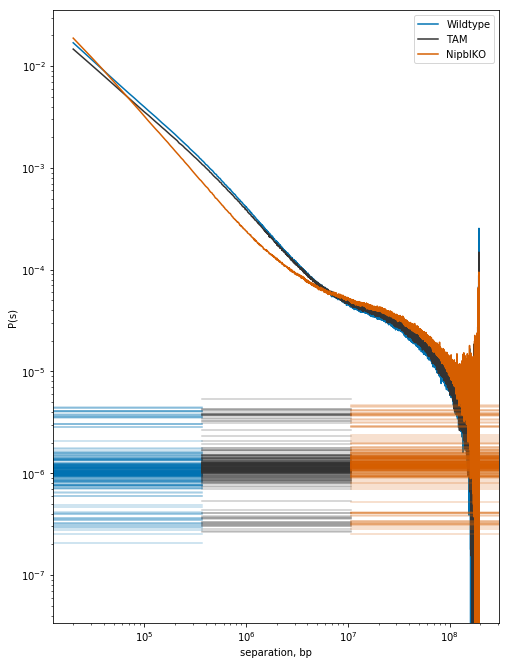

In [13]:
gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=[10, 2])
plt.figure(figsize=(8, 15))

SMOOTH = False

ax1 = plt.subplot(gs[0])
for i, cond in enumerate(conditions):
    
    ref_point = 200000 // binsize
    norm = 1 #scalings[cond][ref_point]
    
    # cis P(s)
    x = np.arange(0, len(scalings[cond]) * binsize, binsize)
    y = scalings[cond] / norm
    if SMOOTH:
        x, y = coarsen_geometric(sums[cond], n_valid[cond], 100)
        x *= binsize
        x = x[:-1]
    
    plt.plot(x, y, 
             color=colors[cond],
             label=long_names[cond])
    
    # average trans levels
    for _, row in trs_exp[cond].iterrows():
        plt.axhline(
            (row['balanced.sum']/row['n_valid']) / norm, 
            xmin=i/len(conditions),
            xmax=(i+1)/len(conditions),
            c=colors[cond], 
            alpha=0.25)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('P(s)')
plt.xlabel('separation, bp')
plt.legend()
plt.gca().set_aspect(1)
xlim = plt.xlim()